In [61]:
import sys, os, glob
import numpy, scipy

def get_info_from_out_log(path):
    assert os.path.exists(path)

    data = []
    for out_log in  glob.glob(os.path.join(path, "**", "out.log"), recursive=True):
        d = {}
        kmesh = out_log.split("/")[4]
        kmesh = [int(x) for x in kmesh.split("-")]
        d["kmesh"] = numpy.prod(kmesh)
        d["method"] = "-".join(out_log.split("/")[5].split("-")[:-1])
        d["ncpu"] = int(out_log.split("/")[5].split("-")[-1])
        d["cell"] = out_log.split("/")[3]
        d["natm"] = 2 if d["cell"] == "diamond-prim" else 8
        d["path"] = out_log

        if "fftisdf-jy" in out_log:
            info = out_log.split("/")[7].split("-")
            d["k0"] = float(info[1]) if len(info) == 4  else None
            d["c0"] = float(info[3]) if len(info) == 4  else float(info[1])

        if "fftisdf-ks" in out_log:
            info = out_log.split("/")[7]
            import re
            # "search from rcut_epsilon-1e-05-ke_epsilon-0.01-isdf_thresh-0.0005"
            d["ke_epsilon"] = float(re.search(r"ke_epsilon-(\d*\.?\d+(?:[eE][-+]?\d+)?)", info).group(1))
            d["rcut_epsilon"] = float(re.search(r"rcut_epsilon-(\d*\.?\d+(?:[eE][-+]?\d+)?)", info).group(1))
            d["isdf_thresh"] = float(re.search(r"isdf_thresh-(\d*\.?\d+(?:[eE][-+]?\d+)?)", info).group(1))

        with open(out_log, "r") as f:
            table = []
            for line in f:
                if "CPU time" in line:
                    key_word = line.split()[3]
                    wall_time = line.split()[8]
                    d["t_" + key_word] = float(wall_time)

                if "###" in line:
                    table.append(line)

            d["table"] = table
            d["lines"] = f.readlines()

            if len(table) == 2:
                keys = table[0][3:].split(",")
                values = table[1][3:].split(",")
                for key, value in zip(keys, values):
                    d[key.strip()] = float(value.strip())

        data.append(d)

    return data

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"

def plot_error(data, ax):
    kmesh = []

    ke_epsilon = []
    rcut_epsilon = []
    isdf_thresh = []
    for d in data:
        kmesh.append(d["kmesh"])
        x = d.get("ke_epsilon", None)
        if x is not None:
            ke_epsilon.append(x)
        x = d.get("rcut_epsilon", None)
        if x is not None:
            rcut_epsilon.append(x)
        x = d.get("isdf_thresh", None)
        if x is not None:
            isdf_thresh.append(x)

    kmesh = numpy.array(kmesh)
    kmesh = numpy.unique(kmesh)
    ke_epsilon   = set(ke_epsilon)
    rcut_epsilon = set(rcut_epsilon)
    isdf_thresh  = set(isdf_thresh)

    natm = data[0]["natm"]
    d0 = [d for d in data if d["method"] == "fftdf-occri" and d["ncpu"] == 1]
    d1 = [d for d in data if d["method"] == "fftisdf-ks" and d["ncpu"] == 1]

    print(d0, d1)

    cell = d1[0]["cell"].split("-")
    ax.text(0.05, 0.80, f"%s %s" % (cell[1], cell[0]), transform=ax.transAxes, fontsize=14)
    ax.axhline(5e-5, color="grey", linestyle="--", alpha=0.5)
    ax.grid(True, which="major", alpha=0.5, linestyle="--", axis="x")

    def gen_xy(x, y):
        x = numpy.array(x)
        y = numpy.array(y)
        m = numpy.argsort(x)
        x = x[m] * natm
        y = y[m]

        y = y / x

        return numpy.log2(x), y

    for ke in numpy.sort(list(ke_epsilon)):
        for rcut in numpy.sort(list(rcut_epsilon)):
            for isdf in numpy.sort(list(isdf_thresh)):
                x0 = numpy.array([d["kmesh"] for d in d0])
                y0 = numpy.array([d.get("e_tot", numpy.nan) for d in d0])

                x1 = numpy.array([d["kmesh"] for d in d1 if d.get("ke_epsilon", None) == ke and d.get("rcut_epsilon", None) == rcut and d.get("isdf_thresh", None) == isdf])
                y1 = numpy.array([d.get("e_tot", numpy.nan) for d in d1 if d.get("ke_epsilon", None) == ke and d.get("rcut_epsilon", None) == rcut and d.get("isdf_thresh", None) == isdf])

                print("x0 = ", x0)
                print("y0 = ", y0)
                print("x1 = ", x1)
                print("y1 = ", y1)

                x, y = gen_xy(x0, abs(y0 - y1) + 1e-6)
                ax.semilogy(x, y, linestyle="-", marker="s", markersize=4, label=f"KE_EPS = {ke:.2e}, ISDF_THRESH = {isdf:.2e}, RCUT_EPS = {rcut:.2e}")

                ax.set_ylim(8e-7, 0.1)
                ax.set_yticks([1e-6, 1e-4, 1e-2])




[{'kmesh': 32, 'method': 'fftdf-occri', 'ncpu': 1, 'cell': 'diamond-prim', 'natm': 2, 'path': '../work/run-scf-spc/diamond-prim/2-4-4/fftdf-occri-1/100/out.log', 't_build': 28.74, 't_vj': 121.78, 't_vk': 464.67, 'table': ['###  ke_cutoff,        e_tot\n', '###   1.00e+02,  -356.613582\n'], 'lines': [], 'ke_cutoff': 100.0, 'e_tot': -356.613582}, {'kmesh': 64, 'method': 'fftdf-occri', 'ncpu': 1, 'cell': 'diamond-prim', 'natm': 2, 'path': '../work/run-scf-spc/diamond-prim/4-4-4/fftdf-occri-1/100/out.log', 't_build': 106.8, 't_vj': 1021.83, 'table': [], 'lines': []}, {'kmesh': 1, 'method': 'fftdf-occri', 'ncpu': 1, 'cell': 'diamond-prim', 'natm': 2, 'path': '../work/run-scf-spc/diamond-prim/1-1-1/fftdf-occri-1/100/out.log', 't_build': 2.33, 't_vj': 0.2, 't_vk': 0.03, 'table': ['###  ke_cutoff,        e_tot\n', '###   1.00e+02,    -9.590934\n'], 'lines': [], 'ke_cutoff': 100.0, 'e_tot': -9.590934}, {'kmesh': 16, 'method': 'fftdf-occri', 'ncpu': 1, 'cell': 'diamond-prim', 'natm': 2, 'path': 

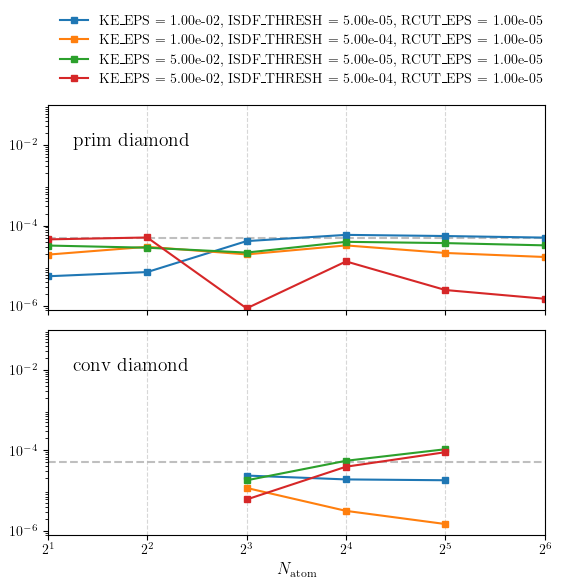

In [62]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

diamond_prim_s = get_info_from_out_log("../work/run-scf-spc/diamond-prim")
plot_error(diamond_prim_s, axs[0])

diamond_conv_s = get_info_from_out_log("../work/run-scf-spc/diamond-conv")
plot_error(diamond_conv_s, axs[1])

axs[-1].set_xlabel(r"$N_{\mathrm{atom}}$", fontsize=12)

xx = [i for i in range(1, 7)]
axs[-1].set_xticks(xx)
axs[-1].set_xticklabels([r"$2^{%d}$" % i for i in xx])
axs[-1].set_xlim(xx[0], xx[-1])

axs[0].legend(loc="upper left", bbox_to_anchor=(0, 1.5), ncol=1, fontsize=10, frameon=False, columnspacing=4.0)

fig.tight_layout()
# fig.show()


In [63]:
def plot_time(data):
    """
    Plot timing data for different methods (fftisdf, fftdf, gdf).
    
    Parameters:
    -----------
    data : list of dict
        Raw data containing timing information for different methods
    """
    import matplotlib.pyplot as plt
    import numpy
    
    # Process the data to separate by method
    dd = [d for d in data if d["method"] == "fftisdf-ks" and d["ncpu"] == 1]
    dd = sorted(dd, key=lambda x: x["kmesh"])
    print(dd)
    
    df = [d for d in data if d["method"] == "fftdf-occri" and d["ncpu"] == 1]
    df = sorted(df, key=lambda x: x["kmesh"])
    
    dg = [d for d in data if d["method"] == "gdf" and d["ncpu"] == 1]
    dg = sorted(dg, key=lambda x: x["kmesh"])
    
    fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
    
    # Common setup
    titles = ["Build time (s)", "J time (s)", "K time (s)"]
    time_keys = ["t_build", "t_vj", "t_vk"]
    colors = ["b", "g", "r"]
    markers = ["s", "s", "s"]
    
    natm = dd[0]["natm"]
    
    for i, (ax, title, time_key) in enumerate(zip(axs, titles, time_keys)):
        ax.set_ylabel(title, fontsize=12)
        ax.grid(True, which="major", alpha=0.5, linestyle="--")
        
        # Plot fftisdf data
        x = numpy.array([d["kmesh"] for d in dd])
        y = numpy.array([d.get(time_key, numpy.nan) for d in dd])
        m = numpy.argsort(x)
        x = x[m] * natm
        xx = numpy.log2(x)
        ax.semilogy(xx, y, label="FFTISDF-KS", color=colors[0], linestyle="-", marker=markers[0], markersize=6, base=2)
        
        # Plot fftdf data
        # if not time_key == "t_build":
        x = numpy.array([d["kmesh"] for d in df])
        y = numpy.array([d.get(time_key, numpy.nan) + 1e-2 for d in df])
        if time_key == "t_build":
            y *= 0.0
        m = numpy.argsort(x)
        x = x[m] * natm
        xx = numpy.log2(x)
        ax.semilogy(xx, y, label="FFTDF", color=colors[1], linestyle="-", marker=markers[1], markersize=6, base=2)
        
        # Plot gdf data
        x = numpy.array([d["kmesh"] for d in dg])
        y = numpy.array([d.get(time_key, numpy.nan) + 1e-2 for d in dg])
        m = numpy.argsort(x)
        x = x[m] * natm
        xx = numpy.log2(x)
        ax.semilogy(xx, y, label="GDF", color=colors[2], linestyle="-", marker=markers[2], markersize=6, base=2)
    
    # Set x-axis limits and ticks
    cell = dd[0]["cell"].split("-")
    axs[0].text(0.05, 0.80, f"%s %s" % (cell[1], cell[0]), transform=axs[0].transAxes, fontsize=14)
    xx = [i for i in range(3, 8)]
    axs[-1].set_xticks(xx)
    axs[-1].set_xticklabels([r"$2^{%d}$" % i for i in xx])
    axs[-1].set_xlim(xx[0], xx[-1])
    axs[-1].set_xlabel(r"$N_{\mathrm{atom}}$", fontsize=12)
    
    # Add legend to the top plot
    axs[0].legend(
        loc="upper left",
        bbox_to_anchor=(0, 1.3),
        ncol=3, fontsize=12,
        frameon=False, columnspacing=4.0
    )
    
    fig.tight_layout()
    plt.show()
    
    # return fig, axs

[{'kmesh': 1, 'method': 'fftisdf-ks', 'ncpu': 1, 'cell': 'diamond-prim', 'natm': 2, 'path': '../work/run-scf-spc/diamond-prim/1-1-1/fftisdf-ks-1/100/rcut_epsilon-1e-05-ke_epsilon-0.01-isdf_thresh-0.0005/out.log', 'ke_epsilon': 0.01, 'rcut_epsilon': 1e-05, 'isdf_thresh': 0.0005, 't_build': 3.68, 't_vj': 0.16, 't_vk': 0.02, 'table': ['###    ke_cutoff, rcut_epsilon,   ke_epsilon,  isdf_thresh,        e_tot\n', '###     1.00e+02,     1.00e-05,     1.00e-02,     5.00e-04,    -9.590897\n'], 'lines': [], 'ke_cutoff': 100.0, 'e_tot': -9.590897}, {'kmesh': 1, 'method': 'fftisdf-ks', 'ncpu': 1, 'cell': 'diamond-prim', 'natm': 2, 'path': '../work/run-scf-spc/diamond-prim/1-1-1/fftisdf-ks-1/100/rcut_epsilon-1e-05-ke_epsilon-0.05-isdf_thresh-5e-05/out.log', 'ke_epsilon': 0.05, 'rcut_epsilon': 1e-05, 'isdf_thresh': 5e-05, 't_build': 0.82, 't_vj': 0.16, 't_vk': 0.02, 'table': ['###    ke_cutoff, rcut_epsilon,   ke_epsilon,  isdf_thresh,        e_tot\n', '###     1.00e+02,     1.00e-05,     5.00e-02,

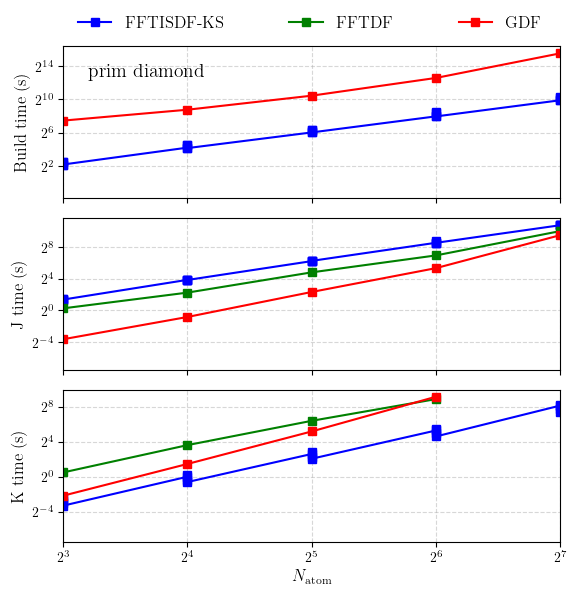

In [64]:
plot_time(diamond_prim_s)

[{'kmesh': 1, 'method': 'fftisdf-ks', 'ncpu': 1, 'cell': 'diamond-conv', 'natm': 8, 'path': '../work/run-scf-spc/diamond-conv/1-1-1/fftisdf-ks-1/100/rcut_epsilon-1e-05-ke_epsilon-0.01-isdf_thresh-0.0005/out.log', 'ke_epsilon': 0.01, 'rcut_epsilon': 1e-05, 'isdf_thresh': 0.0005, 't_build': 5.04, 't_vj': 0.74, 't_vk': 0.21, 'table': ['###    ke_cutoff, rcut_epsilon,   ke_epsilon,  isdf_thresh,        e_tot\n', '###     1.00e+02,     1.00e-05,     1.00e-02,     5.00e-04,   -43.263985\n'], 'lines': [], 'ke_cutoff': 100.0, 'e_tot': -43.263985}, {'kmesh': 1, 'method': 'fftisdf-ks', 'ncpu': 1, 'cell': 'diamond-conv', 'natm': 8, 'path': '../work/run-scf-spc/diamond-conv/1-1-1/fftisdf-ks-1/100/rcut_epsilon-1e-05-ke_epsilon-0.05-isdf_thresh-5e-05/out.log', 'ke_epsilon': 0.05, 'rcut_epsilon': 1e-05, 'isdf_thresh': 5e-05, 't_build': 3.21, 't_vj': 0.4, 't_vk': 0.11, 'table': ['###    ke_cutoff, rcut_epsilon,   ke_epsilon,  isdf_thresh,        e_tot\n', '###     1.00e+02,     1.00e-05,     5.00e-02,

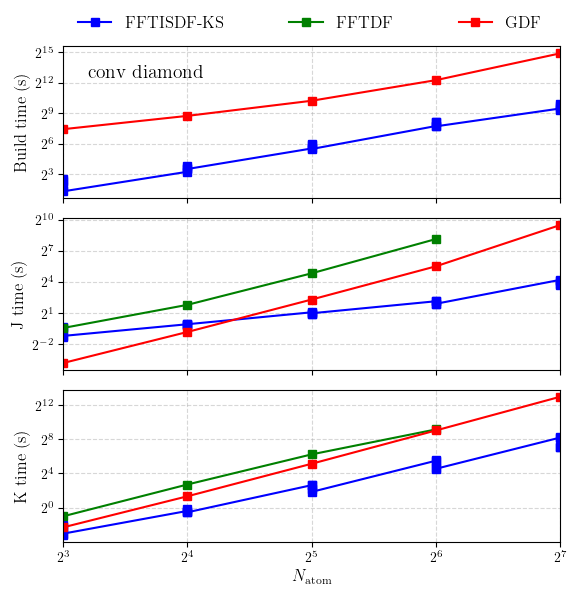

In [65]:
plot_time(diamond_conv_s)

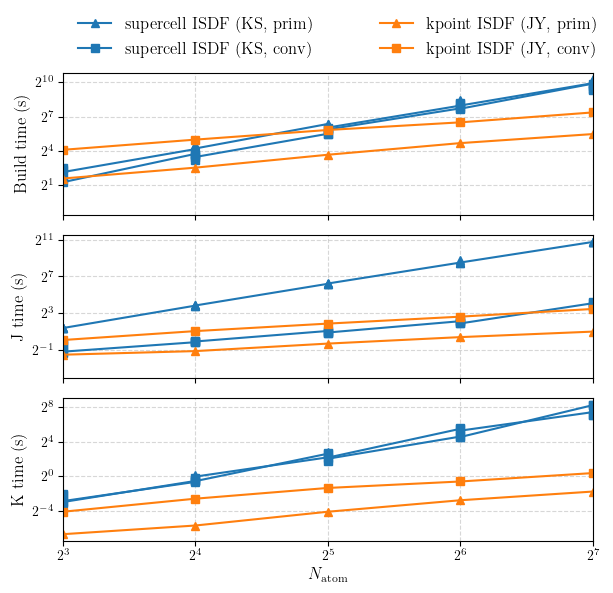

In [66]:
diamond_prim_k = get_info_from_out_log("../work/run-scf-kpt/diamond-prim")
diamond_conv_k = get_info_from_out_log("../work/run-scf-kpt/diamond-conv")

diamond_prim_s = get_info_from_out_log("../work/run-scf-spc/diamond-prim")
diamond_conv_s = get_info_from_out_log("../work/run-scf-spc/diamond-conv")

import matplotlib.pyplot as plt
import numpy

d1 = [d for d in diamond_prim_s if d["method"] == "fftisdf-ks" and d["ncpu"] == 1]
d2 = [d for d in diamond_conv_s if d["method"] == "fftisdf-ks" and d["ncpu"] == 1]
d3 = [d for d in diamond_prim_k if d["method"] == "fftisdf-jy" and d["ncpu"] == 1]
d3 = [d for d in d3 if d.get("k0", None) == 40.0 and d.get("c0", None) == 10.0]
d4 = [d for d in diamond_conv_k if d["method"] == "fftisdf-jy" and d["ncpu"] == 1]
d4 = [d for d in d4 if d.get("k0", None) == 40.0 and d.get("c0", None) == 10.0]

fig, axs = plt.subplots(3, 1, figsize=(6.5, 6), sharex=True)

# Common setup
titles = ["Build time (s)", "J time (s)", "K time (s)"]
time_keys = ["t_build", "t_vj", "t_vk"]
colors = ["tab:blue", "tab:orange"]

for i, (ax, title, time_key) in enumerate(zip(axs, titles, time_keys)):
    ax.set_ylabel(title, fontsize=12)
    ax.grid(True, which="major", alpha=0.5, linestyle="--")
    
    # Plot fftisdf data
    x = numpy.array([d["kmesh"] for d in d1])
    y = numpy.array([d.get(time_key, numpy.nan) for d in d1])
    m = numpy.argsort(x)
    x = x[m] * d1[0]["natm"]
    xx = numpy.log2(x)
    y = y[m]
    ax.semilogy(xx, y, label="supercell ISDF (KS, prim) ", color=colors[0], linestyle="-", marker="^", markersize=6, base=2)
    
    # Plot fftdf data
    # if not time_key == "t_build":
    x = numpy.array([d["kmesh"] for d in d2])
    y = numpy.array([d.get(time_key, numpy.nan) + 1e-2 for d in d2])
    m = numpy.argsort(x)
    x = x[m] * d2[0]["natm"]
    xx = numpy.log2(x)
    y = y[m]
    ax.semilogy(xx, y, label="supercell ISDF (KS, conv)", color=colors[0], linestyle="-", marker="s", markersize=6, base=2)
    
    x = numpy.array([d["kmesh"] for d in d3])
    y = numpy.array([d.get(time_key, numpy.nan) for d in d3])
    m = numpy.argsort(x)
    x = x[m] * d3[0]["natm"]
    xx = numpy.log2(x)
    y = y[m]
    ax.semilogy(xx, y, label="kpoint ISDF (JY, prim)", color=colors[1], linestyle="-", marker="^", markersize=6, base=2)
    
    x = numpy.array([d["kmesh"] for d in d4])
    y = numpy.array([d.get(time_key, numpy.nan) for d in d4])
    m = numpy.argsort(x)
    x = x[m] * d4[0]["natm"]
    xx = numpy.log2(x)
    y = y[m]
    ax.semilogy(xx, y, label="kpoint ISDF (JY, conv)", color=colors[1], linestyle="-", marker="s", markersize=6, base=2)

# Set x-axis limits and ticks
# axs[0].text(0.05, 0.80, f"%s %s" % (cell[1], cell[0]), transform=axs[0].transAxes, fontsize=14)
xx = [i for i in range(3, 8)]
axs[-1].set_xticks(xx)
axs[-1].set_xticklabels([r"$2^{%d}$" % i for i in xx])
axs[-1].set_xlim(xx[0], xx[-1])
axs[-1].set_xlabel(r"$N_{\mathrm{atom}}$", fontsize=12)

# Add legend to the top plot
axs[0].legend(
    loc="upper left",
    bbox_to_anchor=(0, 1.5),
    ncol=2, fontsize=12,
    frameon=False, columnspacing=4.0
)

fig.tight_layout()
plt.show()

# 
